In [1]:
from pymle.models.GeometricBM import GeometricBM
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
import numpy as np
import pandas as pd
import yfinance as yf

In [ ]:
# Define the stock tickers to analyze and the date range for data download.
indices: np.ndarray = np.array(["^AXPJ"])
start_date: str = "2015-01-01"
end_date: str = "2025-5-12"
tickers: np.ndarray = np.concatenate(
    [indices],
    axis=0
)

# Download historical market data once for all specified tickers.
# 'actions=True' includes dividends and stock splits.
# 'auto_adjust=False' keeps the original open, high, low, close, and adjusted close columns.
daily_prices: pd.DataFrame = yf.download(", ".join(tickers), start=start_date, end=end_date, actions=True, auto_adjust=False)

# Extract the adjusted closing prices. This is typically used for financial analysis as it accounts for corporate actions.
daily_closes: pd.DataFrame = daily_prices["Adj Close"].copy()

# Calculate the daily percentage change (returns) from the adjusted closing prices.
# 'dropna()' removes the first row which will contain NaN values after percentage change calculation.
daily_returns: pd.DataFrame = daily_closes.pct_change(fill_method=None).dropna()

[*********************100%***********************]  1 of 1 completed

(1,)
['^AXPJ']
Ticker            ^AXPJ
Date                   
2015-01-02  1200.500000
2015-01-05  1211.400024
2015-01-06  1197.300049
2015-01-07  1213.300049
2015-01-08  1226.500000
...                 ...
2025-05-05  1720.500000
2025-05-06  1734.500000
2025-05-07  1747.500000
2025-05-08  1761.599976
2025-05-09  1761.099976

[2619 rows x 1 columns]


In [11]:
model = GeometricBM()

# Set bounds for param search, and some psuedo-reasonable initial guess
param_bounds = [(0.0, 10000), (0.0, 10000)]
guess = np.array([daily_closes["^AXPJ"].mean(), daily_closes["^AXPJ"].std()])

# ===========================
# Read in the data 
# ===========================

sample = daily_closes["^AXPJ"].values
dt = 1. / 252  # Daily observations

# ===========================
# Fit maximum Likelihood estimators
# ===========================

# Fit using Kessler MLE
kessler_mle = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model))
kessler_est_result = kessler_mle.estimate_params(guess)
kessler_params = kessler_est_result.params

print(f'\nKessler MLE: {kessler_params} \n')

print

# Fit using Shoji-Ozaki MLE
shojioz_mle = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model))
shojioz_est_result = shojioz_mle.estimate_params(guess)
shojioz_params = shojioz_est_result.params

print(f'\nShoji-Ozaki MLE: {shojioz_params}')

Initial Params: [1448.36725147  161.07853837]
Initial Likelihood: -43095.81654992601
`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 75, CG iterations: 24, optimality: 1.79e+04, constraint violation: 0.00e+00, execution time: 0.023 s.
Final Params: [1448.36737891  160.33478584]
Final Likelihood: -43071.576868920325

Kessler MLE: [1448.36737891  160.33478584] 

Initial Params: [1448.36725147  161.07853837]
Initial Likelihood: -83751.2025408902
`xtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 81, CG iterations: 27, optimality: 2.62e+09, constraint violation: 0.00e+00, execution time: 0.026 s.
Final Params: [1447.55756865  161.07989503]
Final Likelihood: -40448.29868592261

Shoji-Ozaki MLE: [1447.55756865  161.07989503]



Shoji-Ozaki MLE mu: 1447.5575686484397 

Shoji-Ozaki MLE sigma: 161.07989502578343 



/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/aleatory/processes/analytical/geometric_brownian.py:157: RuntimeWarning: overflow encountered in exp
  return self.initial * np.exp(self.drift * times)
/opt/anaconda3/envs/MainEnvironment/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


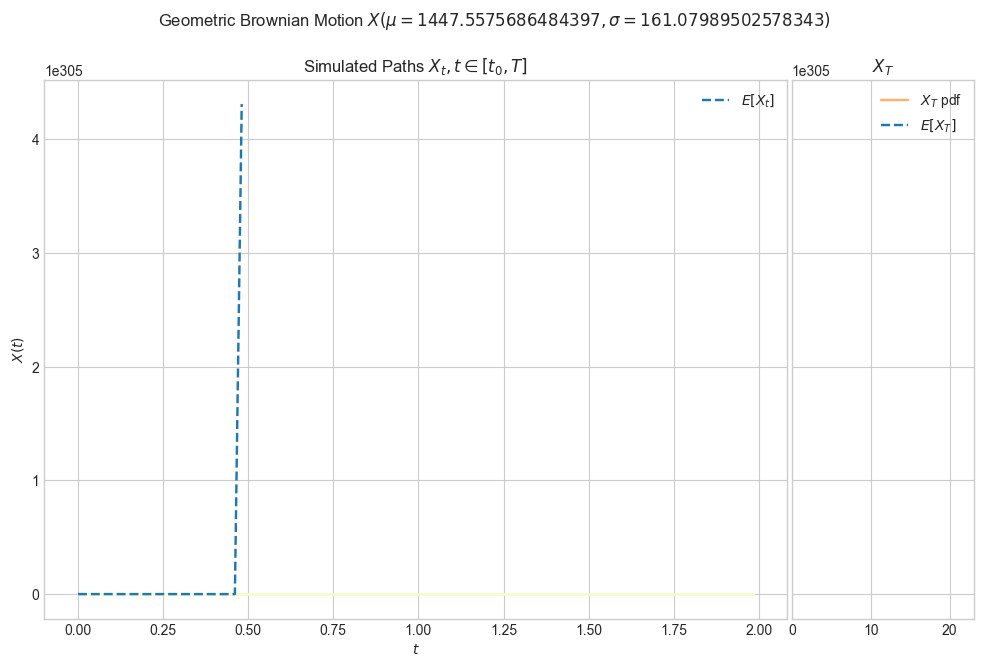

/var/folders/gj/n6dwtv650h79sxt750cq8mp00000gn/T/ipykernel_30422/2142741672.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
from aleatory.processes import GBM
mu, sigma = shojioz_params
# print(f'\nShoji-Ozaki MLE mu: {mu} \n')
# print(f'Shoji-Ozaki MLE sigma: {sigma} \n')

paths = 100
steps = 500
dt = 1. / 252  # Daily observations
T = steps * dt # Total simulation time in years

process = GBM(drift=mu, volatility=sigma, initial=daily_closes["^AXPJ"].iloc[-1], T=T)

fig = process.draw(n=100, N=500, figsize=(12, 7))
fig.show()